<a href="https://colab.research.google.com/github/Prajay404/QCNNFORQSO/blob/main/u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 87.7 MB/s eta 0:00:00


Epoch [10/50], Train Loss: 203.0444, Test Loss: 188.8482
Epoch [20/50], Train Loss: 71.2697, Test Loss: 68.6104
Epoch [30/50], Train Loss: 33.1509, Test Loss: 33.0816
Epoch [40/50], Train Loss: 21.9319, Test Loss: 21.9749
Epoch [50/50], Train Loss: 15.5156, Test Loss: 15.5002
Final Test MSE: 15.5002, R2 Score: -2.1226


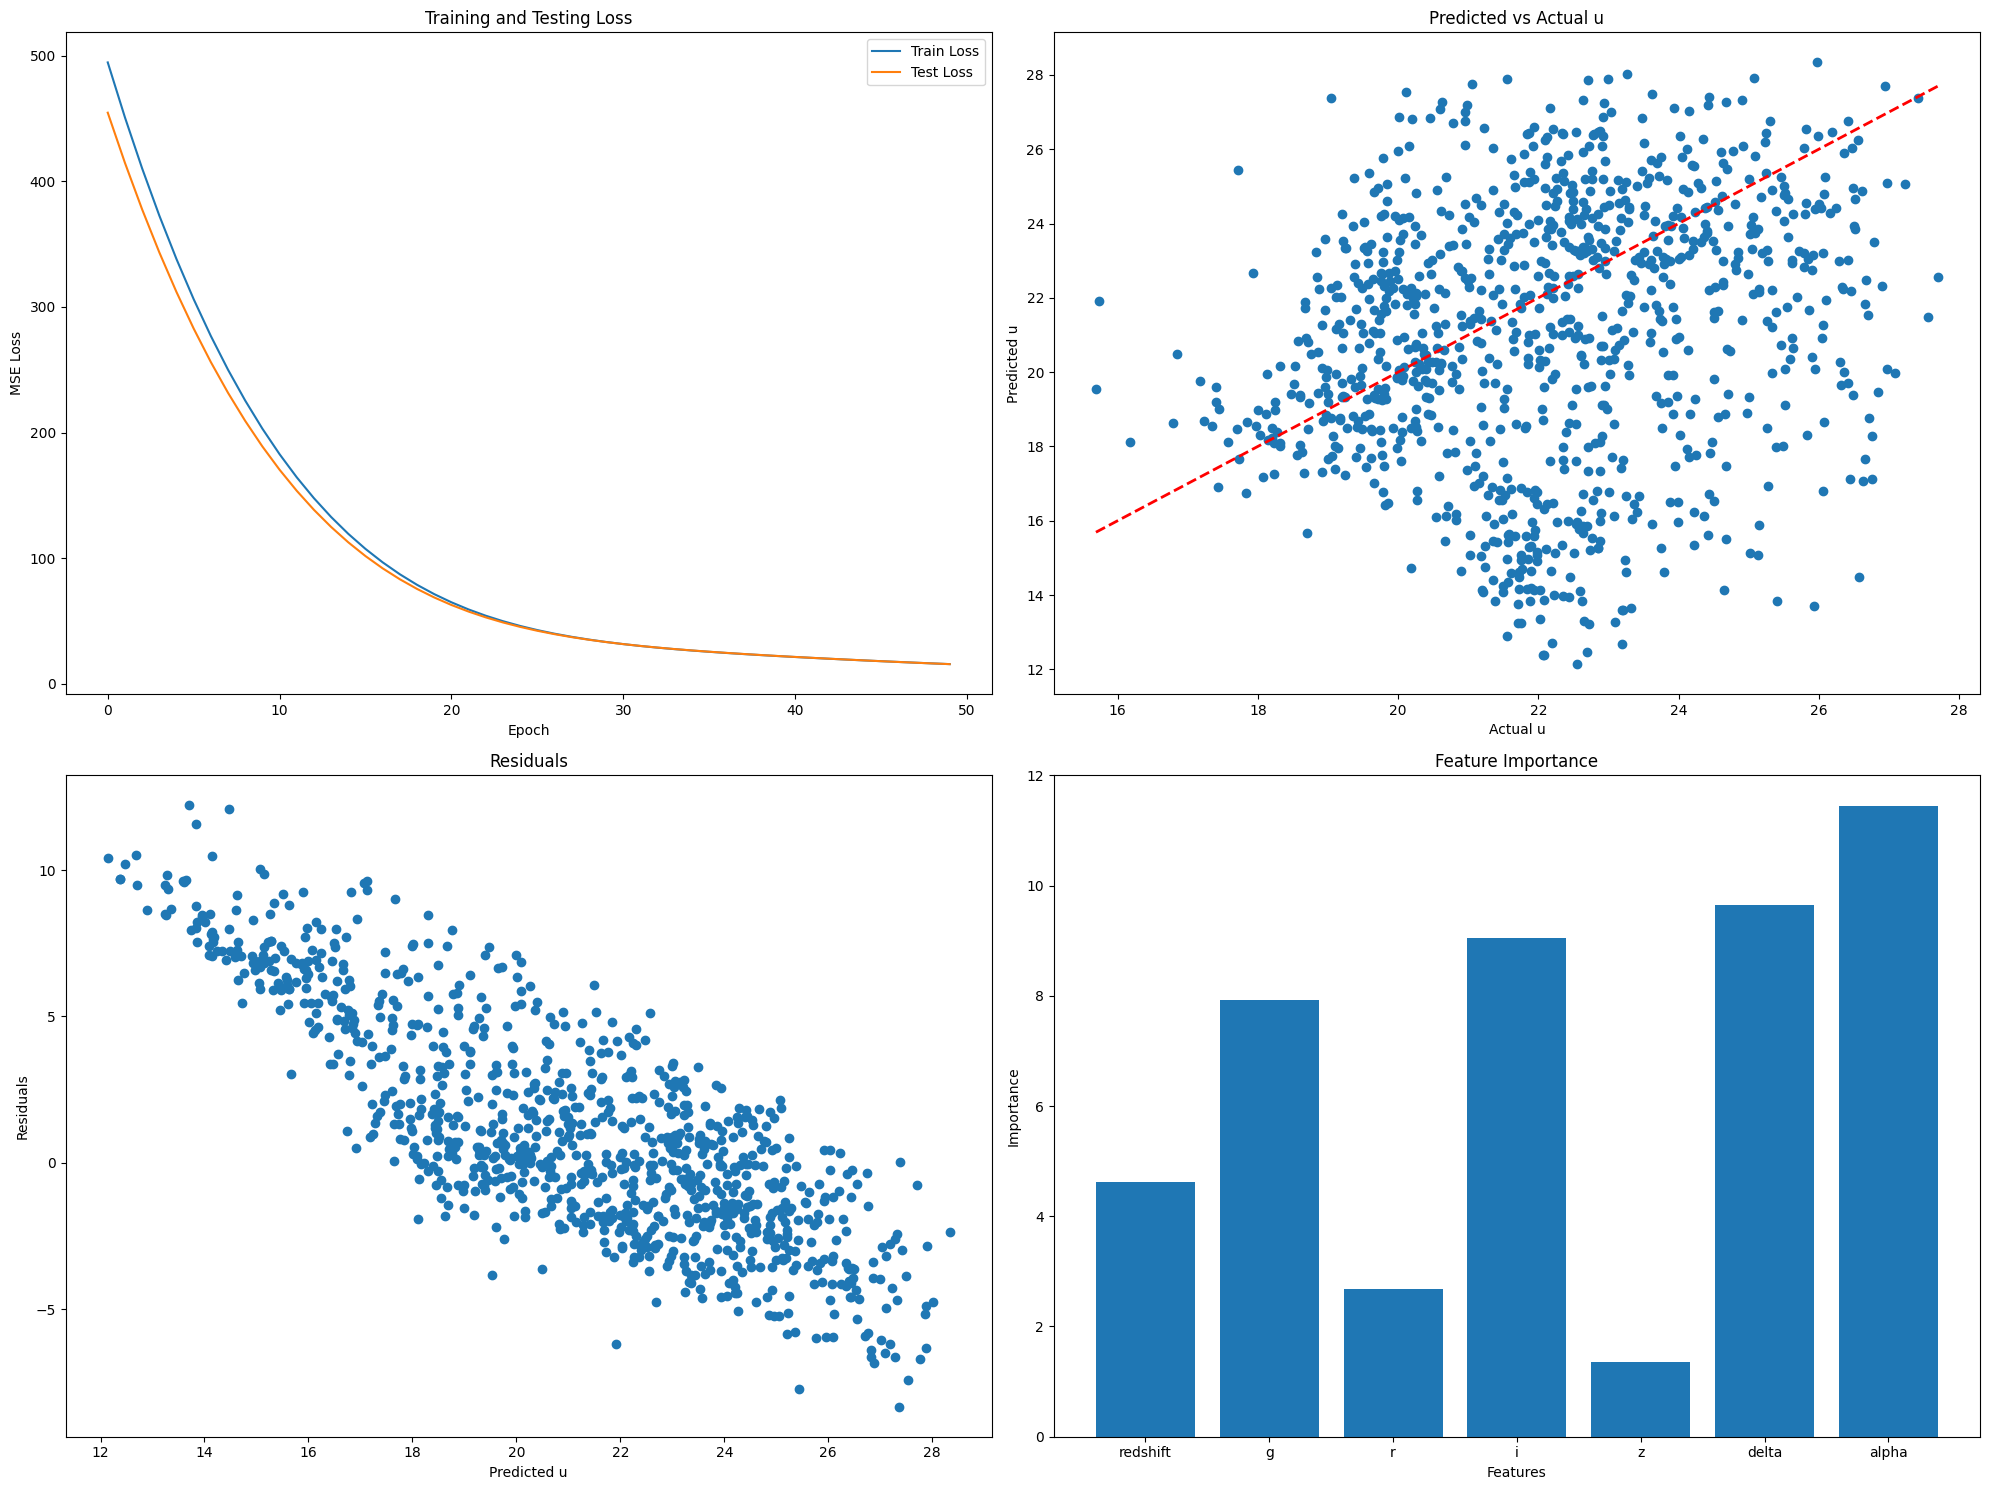

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load and preprocess the data
df = pd.read_csv('/content/star_classification.csv')
X = df[['redshift', 'g', 'r', 'i', 'z', 'delta', 'alpha']]  # Using only the magnitude features
y = df['u']

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train = X_scaled[:2000]
y_train = y[:2000]
X_test = X_scaled[2000:3000]
y_test = y[2000:3000]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define the quantum device
n_qubits = 7  # One qubit for each magnitude feature
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QCNN model
class QCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc = nn.Linear(n_qubits, 1)  # Changed to output a single value for redshift

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers) for x_i in x], dtype=torch.float32)
        return self.fc(x).squeeze()  # Squeeze to remove extra dimension

# Initialize the model
model = QCNN(n_qubits=n_qubits, n_layers=2)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Changed to MSE for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 50
batch_size = 32

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / (len(X_train) // batch_size)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()

    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    mse = mean_squared_error(y_test, test_outputs)
    r2 = r2_score(y_test, test_outputs)
    print(f'Final Test MSE: {mse:.4f}, R2 Score: {r2:.4f}')
# Visualizations
plt.figure(figsize=(20, 15))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, test_outputs.detach().numpy())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual u')
plt.xlabel('Actual u')
plt.ylabel('Predicted u')

# Residuals
plt.subplot(2, 2, 3)
residuals = y_test - test_outputs.detach().numpy()
plt.scatter(test_outputs.detach().numpy(), residuals)
plt.title('Residuals')
plt.xlabel('Predicted u')
plt.ylabel('Residuals')

# Feature Importance
plt.subplot(2, 2, 4)
feature_importance = np.abs(model.fc.weight.detach().numpy()).squeeze()
features = ['redshift', 'g', 'r', 'i', 'z', 'delta', 'alpha']
plt.bar(features, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()


Epoch [10/70], Train Loss: 439.4111, Val Loss: 411.5121
Epoch [20/70], Train Loss: 147.3779, Val Loss: 125.1807
Epoch [30/70], Train Loss: 18.3198, Val Loss: 4.9793
Epoch [40/70], Train Loss: 13.5410, Val Loss: 4.8633
Epoch [50/70], Train Loss: 14.6207, Val Loss: 4.8318
Epoch [60/70], Train Loss: 14.1952, Val Loss: 4.7694
Epoch [70/70], Train Loss: 16.2972, Val Loss: 4.7357
Mean Squared Error: 4.7357
Mean Absolute Error: 1.7750
R2 Score: 0.1308


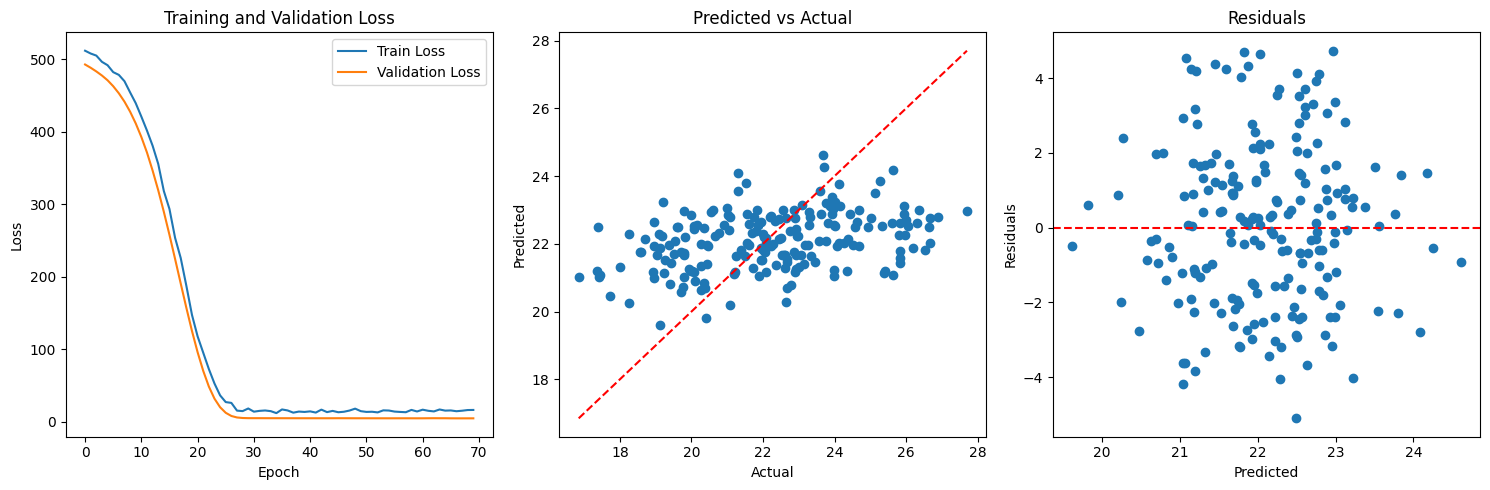

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('/content/star_classification.csv')
X = df[['redshift', 'g', 'r', 'i', 'z', 'delta', 'alpha']]  # Using only the magnitude features
y = df['u']
features = ['redshift', 'g', 'r', 'i', 'z', 'delta', 'alpha']  # Define features here
n_qubits = len(features)
dev = qml.device("default.qubit", wires=n_qubits)

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train = X_scaled[:200]
y_train = y[:200]
X_test = X_scaled[2000:2200]
y_test = y[2000:2200]
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the quantum device
n_qubits = len(features)
dev = qml.device("default.qubit", wires=n_qubits)

# Define an enhanced quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights1, weights2):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights1, wires=range(n_qubits))
    qml.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights2, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define an enhanced QCNN model
class EnhancedQCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers1 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.q_layers2 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc1 = nn.Linear(n_qubits, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers1, self.q_layers2) for x_i in x], dtype=torch.float32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# Initialize the model
model = EnhancedQCNN(n_qubits=n_qubits, n_layers=3)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training loop
n_epochs = 70
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Visualizations (same as before)
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.scatter(y_test.numpy(), y_pred.numpy())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(133)
residuals = y_test.numpy() - y_pred.numpy()
plt.scatter(y_pred.numpy(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [ ]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.1 MB/s eta 0:00:00
